In [181]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [182]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 200
num_epochs = 500
lr = 0.001
num_outputs = 5
batch_size = 500
in_features = 2
noise = False
warm_up_epochs = 5
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
#criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=num_outputs,ys=y))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2111493


In [183]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, seq_len, in_features, num_classes=num_outputs)

| epoch   0 | lr 0.0002 || loss 1.877
| epoch  10 | lr 0.0009996375239002368 || loss 1.046
| epoch  20 | lr 0.0009974242951402235 || loss 0.854
| epoch  30 | lr 0.000993208114306486 || loss 0.936
| epoch  40 | lr 0.0009870059584711668 || loss 0.679
| epoch  50 | lr 0.0009788428015268028 || loss 0.577
| epoch  60 | lr 0.0009687515136252732 || loss 0.592
| epoch  70 | lr 0.0009567727288213005 || loss 0.576
| epoch  80 | lr 0.0009429546814534529 || loss 0.518
| epoch  90 | lr 0.0009273530119214868 || loss 0.491
| epoch 100 | lr 0.0009100305426420956 || loss 0.564
| epoch 110 | lr 0.0008910570250852097 || loss 0.521
| epoch 120 | lr 0.0008705088589094458 || loss 0.498
| epoch 130 | lr 0.0008484687843276468 || loss 0.480
| epoch 140 | lr 0.0008250255489412463 || loss 0.416
| epoch 150 | lr 0.0008002735503850016 || loss 0.417
| epoch 160 | lr 0.0007743124562210351 || loss 0.371
| epoch 170 | lr 0.0007472468026127384 || loss 0.445
| epoch 180 | lr 0.0007191855733945387 || loss 0.384
| epoch 1

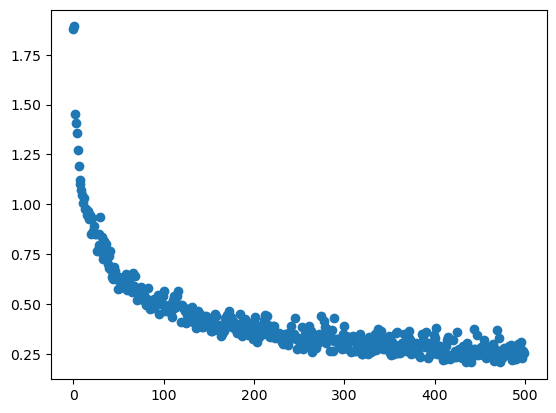

In [184]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

In [219]:
%matplotlib inline
temp_batch_size = 10
seq_len = 100
train_X, train_Y, y_target, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len,num_classes=num_outputs, kmeans=True)
model.eval()
print("")

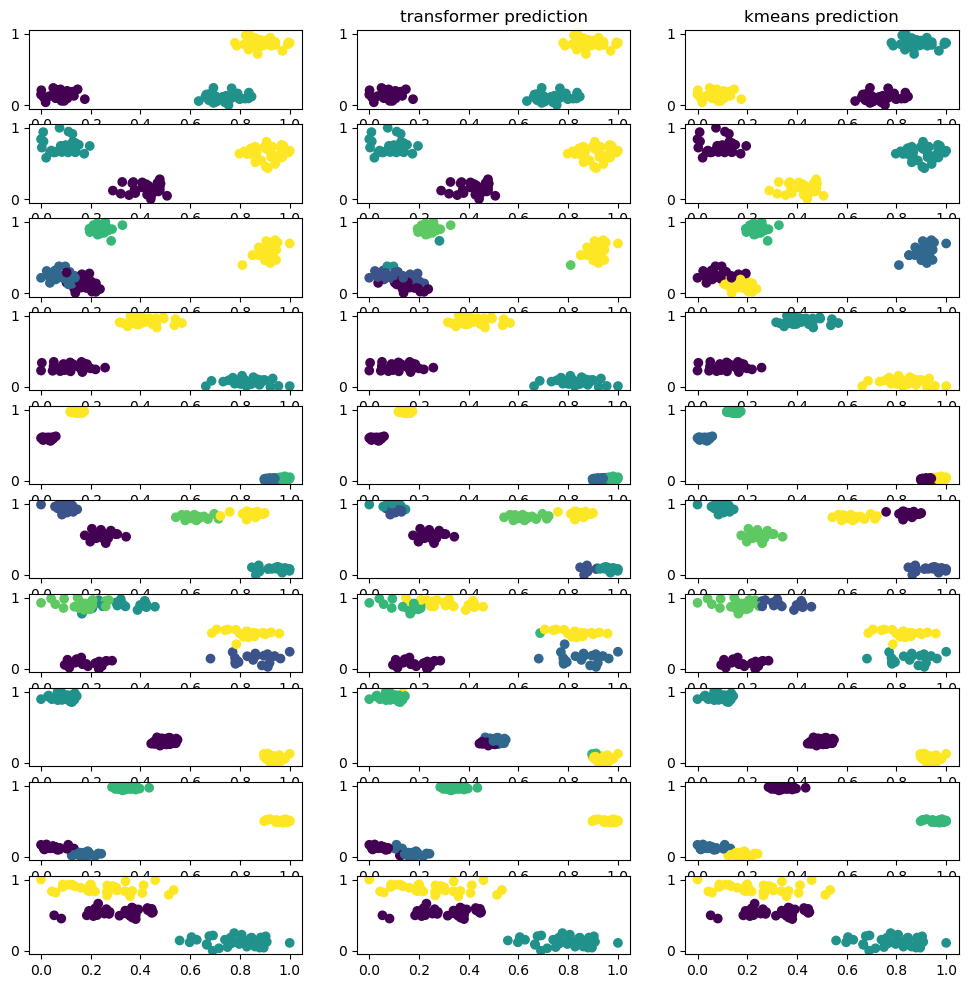

In [220]:
num_points = 50

train_x = train_X[:num_points]
X_total = torch.cat((train_x, train_X), dim=0) 
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(12, 12)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits = model(X_total[:, batch_index], num_points)
    k_labels = utils.k_means(train_x, batch_classes[batch_index])
    predictions = torch.argmax(logits, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[3 * batch_index +2].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=k_labels)
axes[1].set_title(f"transformer prediction")
axes[2].set_title(f"kmeans prediction")
plt.show()

In [254]:
%matplotlib inline
temp_batch_size = 10
seq_len = 100
train_X, train_Y, y_target, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len,num_classes=num_outputs, kmeans=True)
model.eval()
num_points = seq_len

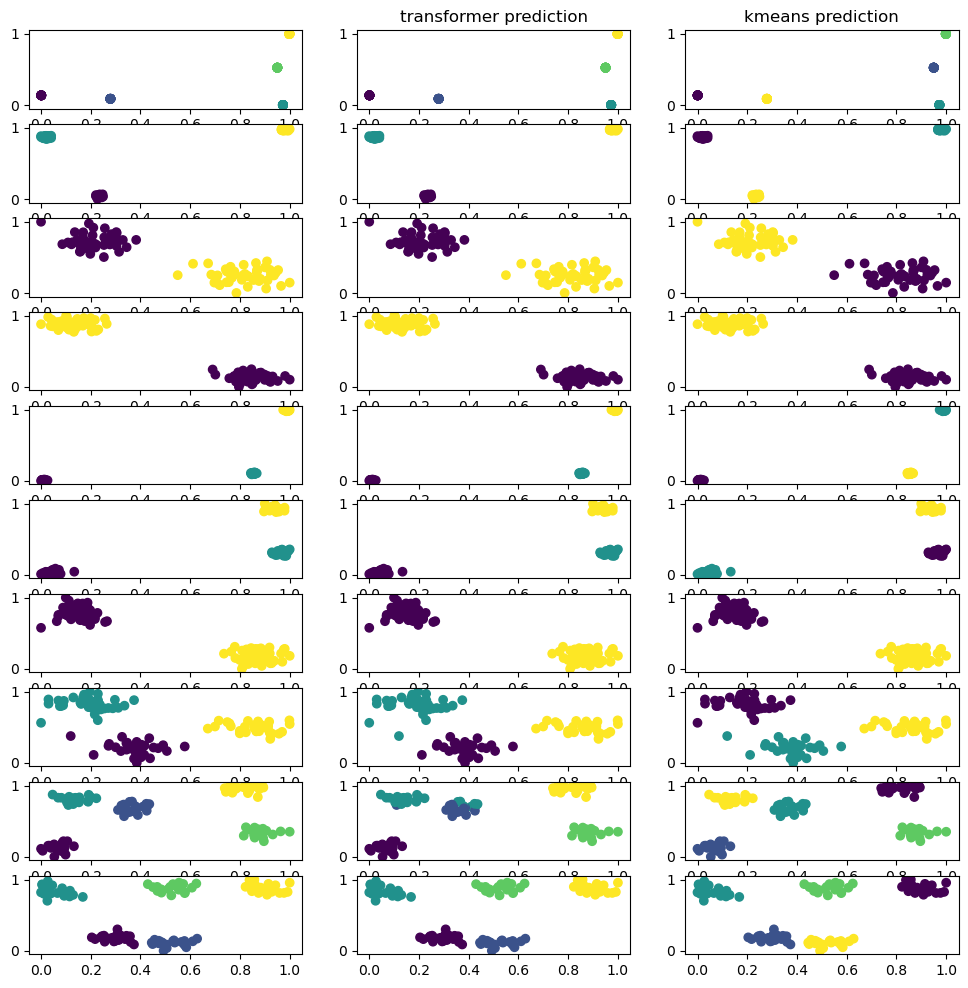

In [255]:
train_x = train_X[:num_points]
X_total = torch.cat((train_x, train_X), dim=0) 
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(12, 12)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits = model(X_total[:, batch_index], num_points)
    k_labels = utils.k_means(train_x, batch_classes[batch_index])
    predictions = torch.argmax(logits, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[3 * batch_index +2].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=k_labels)
axes[1].set_title(f"transformer prediction")
axes[2].set_title(f"kmeans prediction")
plt.show()

In [96]:
# %matplotlib inline
# temp_batch_size = 5
# train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=100)
# model.eval()
# num_points = 50
# # # Set up grid for subplots
# fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
# axes = axes.flatten() 
# for batch_index in range(temp_batch_size):
#     train_x = train_X[:, batch_index]
#     train_y = train_Y[:, batch_index] 
#     axes[2 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
#     logits = model(train_x, num_points)
#     predictions = torch.argmax(logits, dim=1)
#     axes[2 * batch_index +1].scatter(train_X[num_points:,batch_index,0].cpu().numpy() , train_X[num_points:, batch_index, 1].cpu().numpy() , c=predictions.cpu().numpy())
    
# plt.show()



Sorted labels: [94 61 44  8 24  4 99 69 50  9]


In [ ]:
import itertools

def generate_swapped_permutations(arr):
    # Generate all possible swap pairs from the unique integers in the array
    swap_pairs = list(itertools.combinations(set(arr), 2))

    # Store the permutations
    permutations = set()

    # Iterate through all swap pairs
    for swap_pair in swap_pairs:
        swapped_arr = arr[:]
        # Perform the swap for the entire array
        for i in range(len(swapped_arr)):
            if swapped_arr[i] == swap_pair[0]:
                swapped_arr[i] = swap_pair[1]
            elif swapped_arr[i] == swap_pair[1]:
                swapped_arr[i] = swap_pair[0]
        # Add the swapped array to the set of permutations
        permutations.add(tuple(swapped_arr))

    return [list(p) for p in permutations]

# Example usage with the integers 1, 2, 3
arr = [1, 2, 3]
swapped_permutations = generate_swapped_permutations(arr)
for perm in swapped_permutations:
    print(perm)


In [204]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons, make_circles
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
import torch
import random
device = torch.device("cuda")


def sample_clusters(batch_size=100, seq_len=100, num_features=2, type_='make_blobs', noise=False):
    clusters_x = np.zeros((batch_size, seq_len,num_features))
    clusters_y = np.zeros((batch_size, seq_len))
    clusters_y_noisy = []
    for i in range(batch_size):
        std = random.random()
        centers = random.randint(2, 5)
        centers = 2
        x, y = make_blobs(n_samples=seq_len, n_features=num_features, centers=centers, cluster_std=std,
                          shuffle=True)
        x = preprocessing.MinMaxScaler().fit_transform(x)
        x, y = sort(x, y,centers)
        #x = preprocessing.MinMaxScaler().fit_transform(x)
        clusters_x[i] = x 
        clusters_y[i] = y 
        
        if noise:
            # todo add noise to the target
            pass
        else:
            clusters_y_noisy.append(y)

    clusters_x = torch.tensor(clusters_x, dtype=torch.float32)
    clusters_y = torch.tensor(clusters_y , dtype=torch.float32)
    clusters_x = clusters_x.permute(1, 0, 2)
    clusters_y = clusters_y.permute(1, 0)

    return clusters_x.to(device), clusters_y.to(device), clusters_y.to(device)


def sort(x, y, centers):
    distances = np.linalg.norm(x, axis=1)
    sorted_indices = np.argsort(distances)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]

    mapping = {}
    storage = set()
    curr = 0
    for i in range(len(sorted_y)):
        if len(mapping) == centers:
            break
        if sorted_y[i] not in storage:
            mapping[sorted_y[i]] = curr
            storage.add(sorted_y[i])
            curr += 1

    y_mapped = np.array([mapping[number] for number in sorted_y])
    indices = np.random.permutation(len(sorted_x))
    shuffled_x = sorted_x[indices]
    shuffled_y = y_mapped[indices]
    return sorted_x, y_mapped



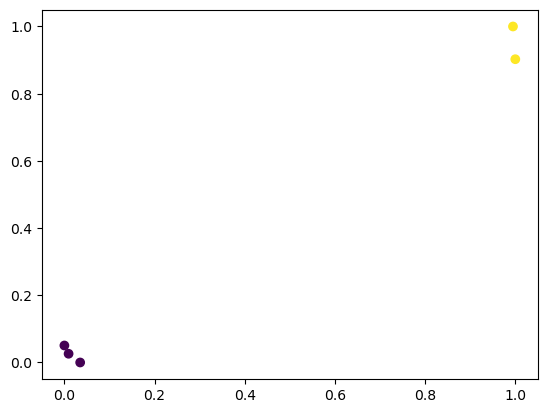

In [205]:
train_X, train_Y, y_target= sample_clusters(batch_size=1,num_features = 2, seq_len=5)

plt.scatter(train_X[:,0,0].cpu().numpy(), train_X[:,0,1].cpu().numpy() , c=train_Y[:,0].cpu().numpy())
plt.show()

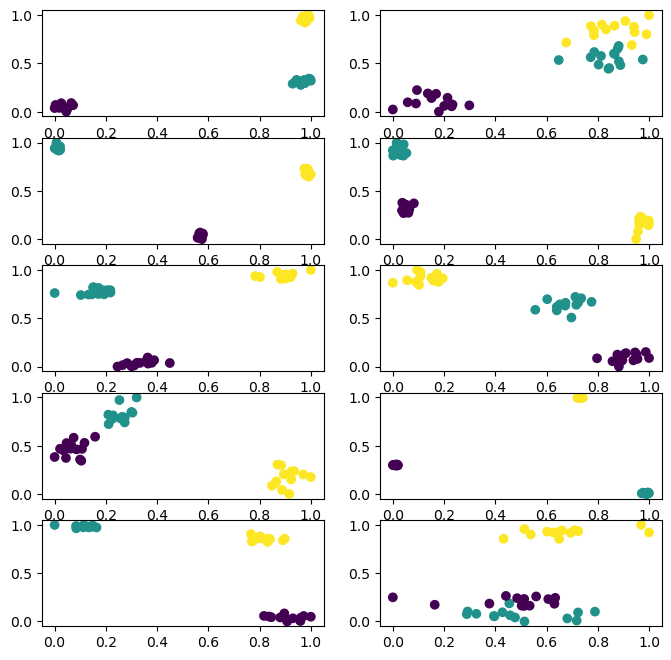

In [219]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=40)
model.eval()
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(8, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    axes[batch_index].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=train_Y[:,batch_index].cpu().numpy())
    
plt.show()



In [ ]:
%matplotlib inline
temp_batch_size = 10
train_X, train_Y, y_target= sample_clusters(batch_size=temp_batch_size,seq_len=100)
model.eval()
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    axes[batch_index].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=train_Y[:,batch_index].cpu().numpy())
    
plt.show()



In [10]:
import itertools

def permute(num_classes):

    # Given integers
    numbers = np.arange(num_classes)

    # Generate all permutations of size 3
    permutation = list(itertools.permutations(numbers, num_classes))

    return permutation

In [15]:
temp = (permute(2))

In [17]:
temp[0][0]

0

In [1]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [3]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 200
num_epochs = 500
lr = 0.001
num_outputs = 5
batch_size = 500
in_features = 2
noise = False
warm_up_epochs = 5
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\checkpoint_dirichlet_15000.pt", weights_only=True))
model.eval() 

Using device: Quadro P1000
total params:2113157


RuntimeError: Error(s) in loading state_dict for Transformer:
	Missing key(s) in state_dict: "embedding.weight". 
	size mismatch for decoder.weight: copying a param with shape torch.Size([10, 256]) from checkpoint, the shape in current model is torch.Size([5, 384]).
	size mismatch for decoder.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([5]).